In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [9]:
# Função para gerar a série temporal
def generate_series(n_samples):
    n = np.arange(n_samples)
    x = np.sqrt(1 + np.sin(n + np.sin(n)**2))
    return x

# Gerar a série temporal com 1000 amostras
n_samples = 1000
x = generate_series(n_samples)
x[:10]  # Mostrando os primeiros 10 valores da série

array([1.        , 1.41088351, 1.14437694, 1.05895126, 0.09865946,
       0.8026908 , 0.89236927, 1.3827972 , 1.19637518, 1.11901018])

In [10]:
# Preparar os dados para a rede NARX usando janelas deslizantes
def prepare_data(x, p):
    X = np.lib.stride_tricks.sliding_window_view(x, window_shape=p)[:-1]
    X = np.concatenate([X, X[:, 1:]], axis=1)
    y = x[p:]
    return X, y

# Definindo a ordem da realimentação
p = 3
X, y = prepare_data(x, p)

# Visualizar os primeiros 10 conjuntos de dados preparados
X[:10], y[:10]

(array([[1.        , 1.41088351, 1.14437694, 1.41088351, 1.14437694],
        [1.41088351, 1.14437694, 1.05895126, 1.14437694, 1.05895126],
        [1.14437694, 1.05895126, 0.09865946, 1.05895126, 0.09865946],
        [1.05895126, 0.09865946, 0.8026908 , 0.09865946, 0.8026908 ],
        [0.09865946, 0.8026908 , 0.89236927, 0.8026908 , 0.89236927],
        [0.8026908 , 0.89236927, 1.3827972 , 0.89236927, 1.3827972 ],
        [0.89236927, 1.3827972 , 1.19637518, 1.3827972 , 1.19637518],
        [1.3827972 , 1.19637518, 1.11901018, 1.19637518, 1.11901018],
        [1.19637518, 1.11901018, 0.4846752 , 1.11901018, 0.4846752 ],
        [1.11901018, 0.4846752 , 0.68074265, 0.4846752 , 0.68074265]]),
 array([1.05895126, 0.09865946, 0.8026908 , 0.89236927, 1.3827972 ,
        1.19637518, 1.11901018, 0.4846752 , 0.68074265, 0.85154248]))

In [11]:
from sklearn.preprocessing import StandardScaler

# Normalizar os dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Visualizar os primeiros 10 conjuntos de dados normalizados
X_scaled[:10], y_scaled[:10]

(array([[ 0.17278005,  1.38383537,  0.60176359,  1.38383537,  0.60176359],
        [ 1.38449295,  0.59953174,  0.35013233,  0.59953174,  0.35013233],
        [ 0.59855377,  0.34813204, -2.47851872,  0.34813204, -2.47851872],
        [ 0.34662982, -2.47791589, -0.40471261, -2.47791589, -0.40471261],
        [-2.48531142, -0.40601824, -0.14055429, -0.40601824, -0.14055429],
        [-0.40909313, -0.14210301,  1.30405815, -0.14210301,  1.30405815],
        [-0.14462754,  1.30117999,  0.75493043,  1.30117999,  0.75493043],
        [ 1.30166521,  0.75255763,  0.52704285,  0.75255763,  0.52704285],
        [ 0.75189877,  0.52487976, -1.34146451,  0.52487976, -1.34146451],
        [ 0.52374612, -1.34190807, -0.76392507, -1.34190807, -0.76392507]]),
 array([ 0.35065755, -2.4784805 , -0.40431735, -0.14011354,  1.3047476 ,
         0.75552535,  0.52759853, -1.34123052, -0.76359165, -0.26039429]))

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Função para gerar a série temporal
def generate_series(n_samples):
    n = np.arange(n_samples)
    return np.sqrt(1 + np.sin(n + np.sin(n)**2))

# Preparar os dados para a rede NARX usando janelas deslizantes
def prepare_data(x, p):
    X = np.lib.stride_tricks.sliding_window_view(x, window_shape=p)[:-1]
    X = np.concatenate([X, X[:, 1:]], axis=1)
    y = x[p:]
    return X, y

# Definir o modelo NARX usando PyTorch
class NARXModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARXModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Gerar a série temporal
n_samples = 1000
x = generate_series(n_samples)

# Preparar os dados
p = 3  # ordem da realimentação
X, y = prepare_data(x, p)

# Normalizar os dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Dividir os dados em treinamento e teste
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Converter os dados para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Parâmetros do modelo
input_size = X_scaled.shape[1]
hidden_size = 128
output_size = 1

# Inicializar o modelo, a função de perda e o otimizador
model = NARXModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar a rede
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.3138
Epoch [20/100], Loss: 0.0987
Epoch [30/100], Loss: 0.0548
Epoch [40/100], Loss: 0.0400
Epoch [50/100], Loss: 0.0276
Epoch [60/100], Loss: 0.0206
Epoch [70/100], Loss: 0.0154
Epoch [80/100], Loss: 0.0118
Epoch [90/100], Loss: 0.0090
Epoch [100/100], Loss: 0.0070


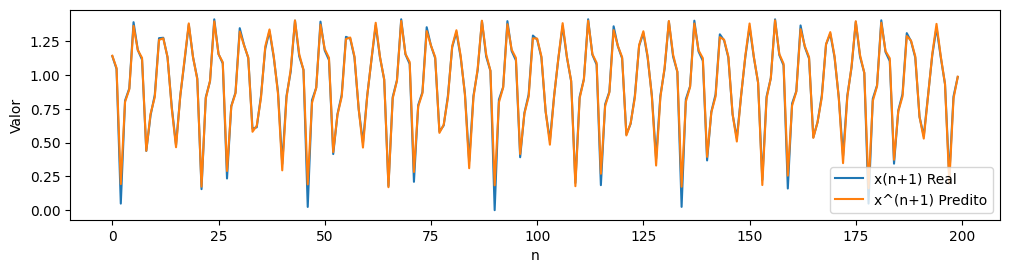

In [20]:
# Predição
model.eval()
y_pred = []
with torch.no_grad():
    previous_window = X_test_tensor[0][:p].numpy()
    for i in range(len(X_test_tensor)):
        if i > 0:
            previous_window = np.roll(previous_window, -1)
            previous_window[-1] = y_pred[-1]

        input_window = np.concatenate((previous_window, X_test_tensor[i][p:]))
        input_tensor = torch.tensor(input_window, dtype=torch.float32).view(1, -1)
        y_pred.append(model(input_tensor).item())

# Converter previsões e dados reais de volta ao formato numpy
y_pred = np.array(y_pred)
y_test = y_test_tensor.numpy()

# Desnormalizar os dados
y_test_denorm = scaler_y.inverse_transform(y_test)
y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Avaliar o desempenho
plt.figure(figsize=(12, 6))

# Curva da série real e predição
plt.subplot(2, 1, 1)
plt.plot(range(len(y_test_denorm)), y_test_denorm, label='x(n+1) Real')
plt.plot(range(len(y_pred_denorm)), y_pred_denorm, label='x^(n+1) Predito')
plt.xlabel('n')
plt.ylabel('Valor')
plt.legend(loc='best')

In [21]:
# Calcular métricas de desempenho
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
r2 = r2_score(y_test_denorm, y_pred_denorm)
evs = explained_variance_score(y_test_denorm, y_pred_denorm)

print(f"mean_absolute_error: {mae}")
print(f"mean_squared_error: {mse}")
print(f"r2_score: {r2}")
print(f"explained_variance_score: {evs}")

mean_absolute_error: 0.016547547627694968
mean_squared_error: 0.0009414877947196701
r2_score: 0.9918540833593982
explained_variance_score: 0.99191786935425


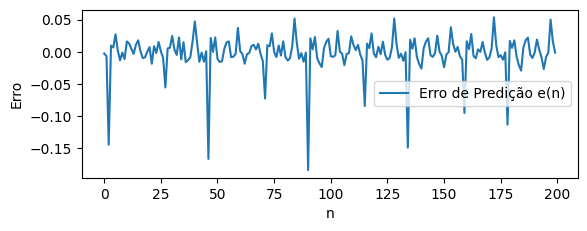

In [22]:
# Curva do erro de predição
plt.subplot(2, 1, 2)
e = y_test_denorm.flatten() - y_pred_denorm.flatten()
plt.plot(range(len(e)), e, label='Erro de Predição e(n)')
plt.xlabel('n')
plt.ylabel('Erro')
plt.legend(loc='best')
